In [1]:
# Contents:
# data (prepare & load)
# build model
# fitting the model to data (training)
# Making predictions & evaluating a model: inference
# saving and loading a model
# putting it all together

In [14]:
import torch
from torch import nn # nn contains all Pytorch building blocks for neural networks
# !conda install matplotlib -y (One-time use to install matplotlib in conda environment)
import matplotlib.pyplot as plt

# Create known data using linear regression formula
# create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]
#len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

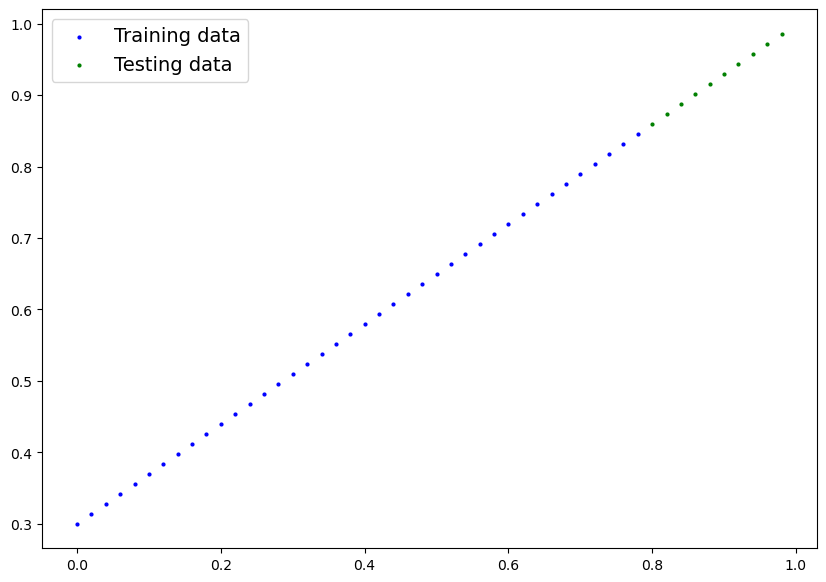

In [24]:
## Splitting data into training and test sets
# Let's create a training and test set with our data
train_split = int(0.8 * len(X))
X_train, Y_train = X[:train_split], y[:train_split]
X_test, Y_test = X[train_split:], y[train_split:]
len(X_train), len(Y_train), len(X_test), len(Y_test)

# Visualize the data better
def plot_predictions(train_data=X_train,
                    train_labels=Y_train,
                    test_data=X_test,
                    test_labels=Y_test,
                    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10,7))

    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show legend
    plt.legend(prop={"size": 14});

plot_predictions();

In [43]:
## Build first PyTorch Model
from torch import nn

# Create linear regression model class
# What our model does:
#   Start with random values (weight and bias)
#   Look at training data and adjust the random values to better represent (or get closer to) the ideal values
#   (i.e. the weight & bias values we used to create data)
#
# How does it do that?
#   1. Gradient descent & 2. Backpropagation

class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                              requires_grad=True,
                                              dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

        # Forward method to define the computation in the model
    def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # linear regression

In [140]:
## PyTorch model building essentials
## Checking contents of PyTorch Model
# Let's see what inside our model

# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.module)
model_0 = LinearRegressionModel()

# 2 ways to list the parameters
#list(model_0.parameters())
model_0.state_dict() # Shows named parameters

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

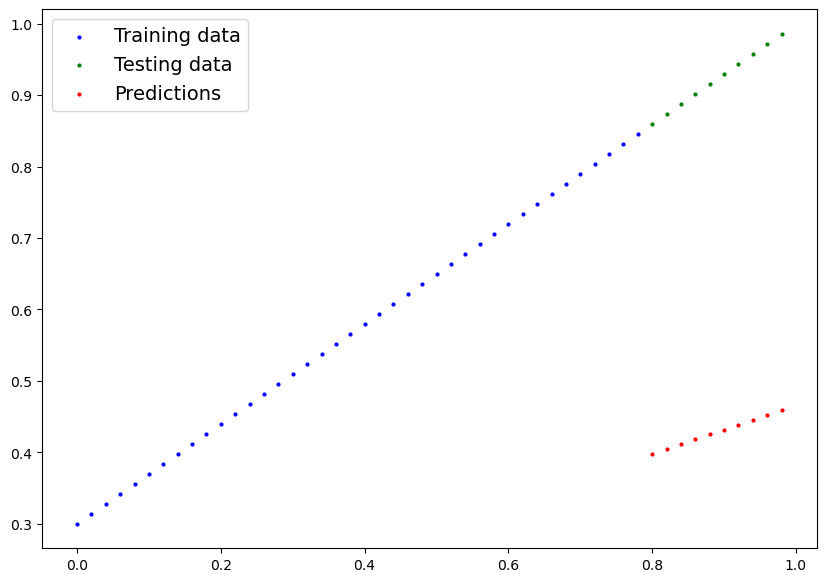

In [141]:
## Check Model's prediction power: predict y_test based on x_test

# this turns off gradient function, as we're in inference mode. Don't keep track of very large data 
# torch.no_grad does this too, but inference mode does other things too and is preferred
with torch.inference_mode(): 
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

In [51]:
## Train model
# This implies a model moving from some unknown/random parameters to some known parameters.
# or in otherwords, a poor representation of the data to a better representation of the data.
# One way to measure how wrong model predictions are is to use a loss function (aka loss function, criterion)

# Loss function: measures how wrong (distance) predictions are to the correct output
# Optimizer: takes into account the loss of a model and adjusts the model's parameters (e.g weight & bias in our case) to improve the loss function value.
#           i.e. decrease the loss     
# we need a training loop and a testing loop, specifically for PyTorch


In [147]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an Optimizer (stochastic gradient descent) p.s. stochastic - random
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01) # lr - learning rate = possibly the most important hyperparameter you set

# Build training & testing loop
# 0. Loop through data
# 1. Forward pass/propagation to make predictions on data (involves data moving through our model)
# 2. Calculate the loss (compare predictions to ground truth labels)
# 3. Optimizer zero grad
# 4. Loss backward (backpropagation) - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss
# 5. Optimizer step (gradient descent) - use the optimizer to adjust our model's parameters to try and improve the loss

# An epoch is one loop through the data... (this is a hyperparameter bc we set it ourselves)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. loop thru data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode sets all parameters that require gradients to require gradients

    # 1. forward-pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, Y_train)
    #print(f"loss: {loss}")

    # 3. Optimizer zero gradient
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss wrt to the model parameters
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # we need to zero the optimizer above, to start fresh with each loop iteration

    ### Testing
    model_0.eval() # turns off other settings not needed for evaluation/testing
    with torch.inference_mode():
        # 1. forward pass
        test_pred = model_0(X_test)

        # 2. calculate the loss
        test_loss = loss_fn(test_pred, Y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

        # print out model values
        #print(model_0.state_dict())

Epoch: 0 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 10 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 20 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 30 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 40 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 50 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 60 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 70 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 80 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 90 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 100 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 110 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 120 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882
Epoch: 130 | Loss: 0.008932482451200485 | Test lo

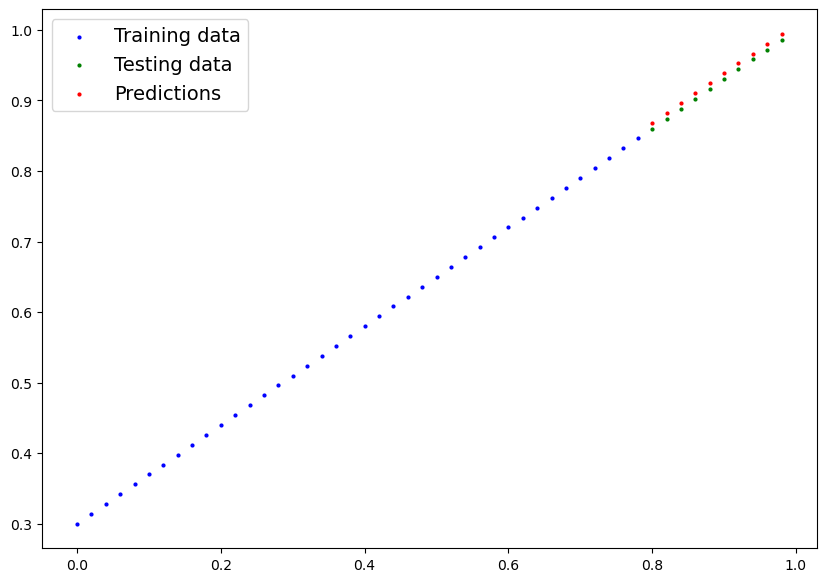

In [143]:
# Make some predictions
with torch.inference_mode(): # turns off gradient tracking 
    y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new);

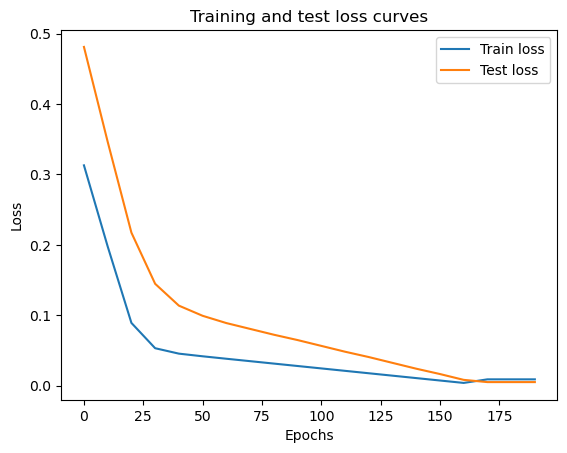

In [146]:
## plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [150]:
### Saving a Model in PyTorch
# 3 main methods for saving and loading models in PyTorch
# 1. torch.save() - save model in python pickle format
# 2. torch.load() - allows you to load a saved PyTorch object
# 3. torch.nn.Module.load_state_dict() - allows you to load a model's saved state dictionary

from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict (recommended)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


In [158]:
### Loading a PyTorch model
# Instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (This will update the instance with updated parameters)
print(f"Loading model...")
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

Loading model...


<All keys matched successfully>

In [160]:
# Testing loaded module with predictions & comparing with original model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

with torch.inference_mode():
    y_preds = model_0(X_test)

loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Using device: cuda


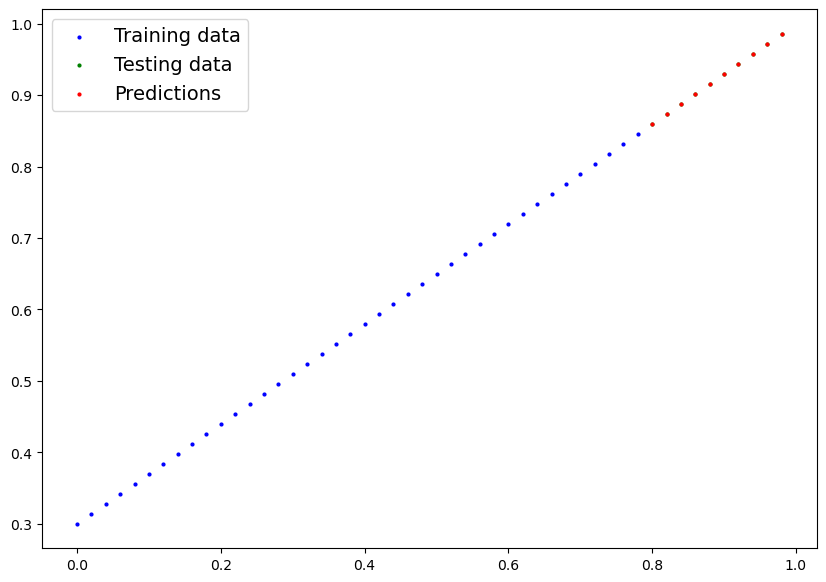

In [185]:
### Putting it all-together
import torch
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# create some data using the linear regression formula: y = mx + c
weight = 0.7
bias = 0.3

# range values
start = 0
end = 1
step = 0.02

# create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Plot data
# plot_predictions(X_train, y_train, X_test, y_test)

# build a PyTorch linear model
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer etc
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
#model_1, model_1.state_dict()


# set the model to use the target device
# next(model_1.parameters()).device # check the model current device
model_1.to(device)
next(model_1.parameters()).device

# train model: (needed items: Loss function, optimizer, training & testing loop)
loss_fn = nn.L1Loss() # same as MAE

# setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# write a training loop
epochs = 200
for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    y_pred = model_1(X_train)

    # 2. calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Saving model to: models\01_pytorch_workflow_model_1.pth


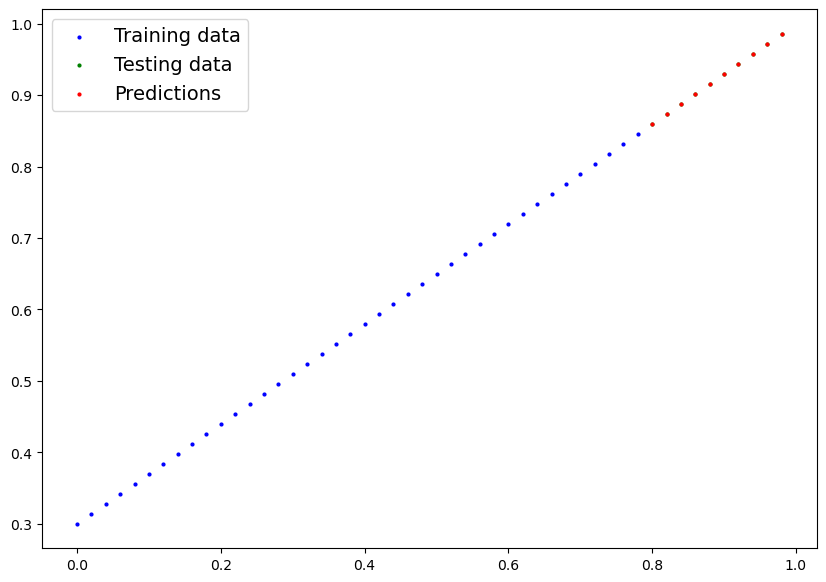

In [187]:
## Making and evaluating predictions
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

In [189]:
### Save & load model_1
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict (recommended)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

# load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

loaded_model_1.to(device)
loaded_model_1.parameters()

Saving model to: models\01_pytorch_workflow_model_1.pth


<generator object Module.parameters at 0x00000194A65509E0>

In [191]:
# Evaluate loaded model
loaded_model_1.eval()

with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')